In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
# Import forecast data data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds, engine='netcdf4')

In [4]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

# Vertical velocity 

In [5]:
# Plot settings

# UK
lat_max = 62
lat_min = 47
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

In [6]:
euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 5, 48, 60]
from cmcrameri import cm

In [18]:
exp['curr']

<xarray.Dataset>
Dimensions:    (time: 97, inidate: 4, longitude: 289, latitude: 163, level: 13, number: 50)
Coordinates:
  * time       (time) datetime64[ns] 2023-10-11 ... 2023-10-23
  * inidate    (inidate) datetime64[ns] 2023-10-11 2023-10-13 ... 2023-10-17
  * longitude  (longitude) float32 -27.0 -26.75 -26.5 -26.25 ... 44.5 44.75 45.0
  * latitude   (latitude) float32 73.5 73.25 73.0 72.75 ... 33.5 33.25 33.0
  * level      (level) int32 10 50 100 200 250 300 400 500 600 700 850 925 1000
  * number     (number) int32 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
Data variables:
    z          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    t          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    q          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    w          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    vo         (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    d          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    u          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    v          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
    r          (time, inidate, number, level, latitude, longitude) float32 dask.array<chunksize=(2, 1, 50, 13, 163, 289), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-18 12:46:47 GMT by grib_to_netcdf-2.32.0: /opt/ecmw...

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


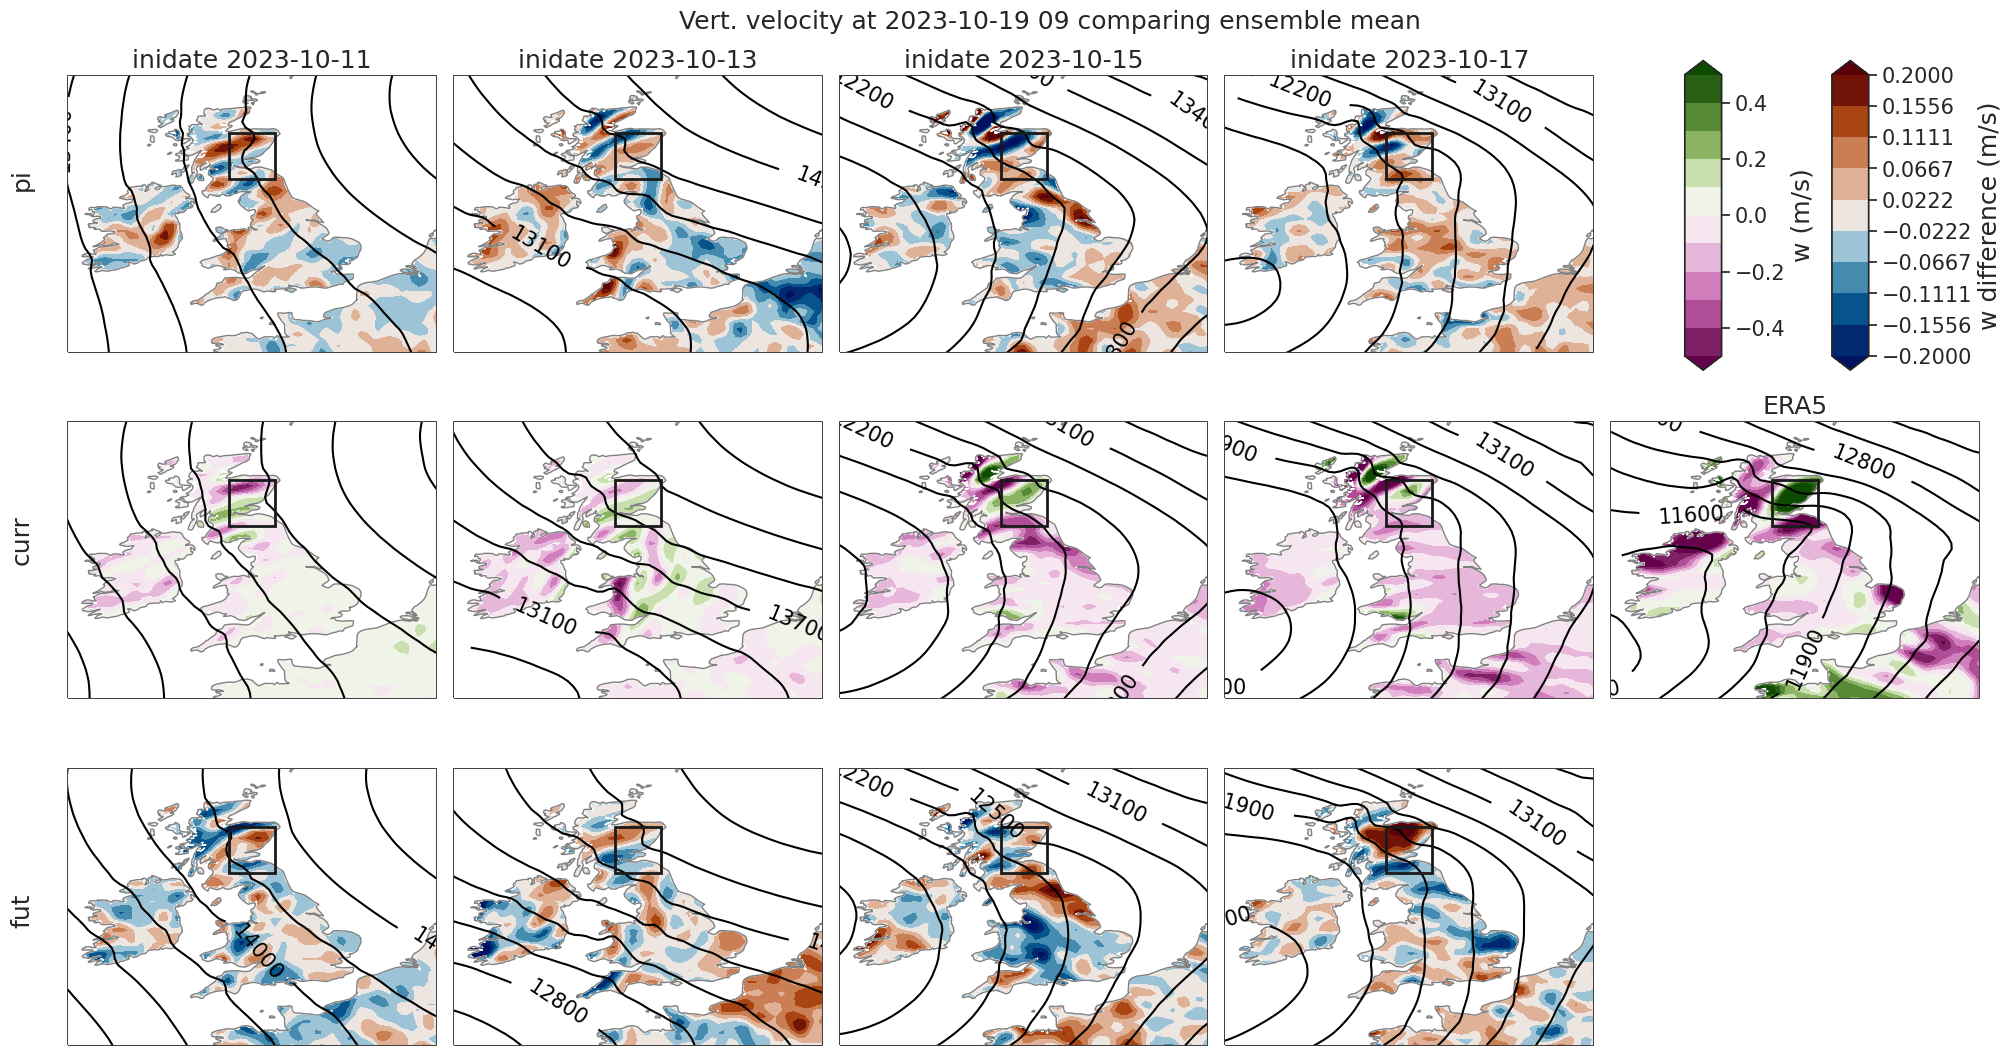

In [56]:
# figure and map setup
experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
p_max = 15000
p_min = 11000

w_min = -0.5
w_max = 0.5

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        p_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=850)).mean(dim='number').z.values

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            w_vals = (exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            w_vals = exp[experiment].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # tp as shading
        if experiment =='curr':
            clevs_w = np.linspace(w_min, w_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                            transform=projection, zorder = 10, extend = 'both')
        else: 
            clevs_w = np.linspace(-0.2, 0.2, 10)
            cf_diff = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.vik,
                                  transform=projection, zorder = 10, extend = 'both')
        
        # isobars as contours
        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

p_vals = era5.z.sel(time=timestep, level=850).values
w_vals = era5.w.sel(time=timestep, level=500).values
ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  # zorder > 10

# tp as shading
clevs_w = np.linspace(w_min, w_max, 11)  # 17
cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')

# isobars as contours
clevs_p = np.arange(p_min, p_max, 300)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black', # clevs_p,
                transform=projection, zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='w (Pa/s)', extend = 'max', shrink=0.8)
cbar.set_label(label='w (Pa/s)', size=fs)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='w difference (Pa/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='w difference (Pa/s)', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('Vert. velocity at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

plt.savefig('figures/08_w_{}.png'.format(timestep), dpi=600)
plt.savefig('figures/08_w_{}.pdf'.format(timestep))

# Upper level winds and relative humidity

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


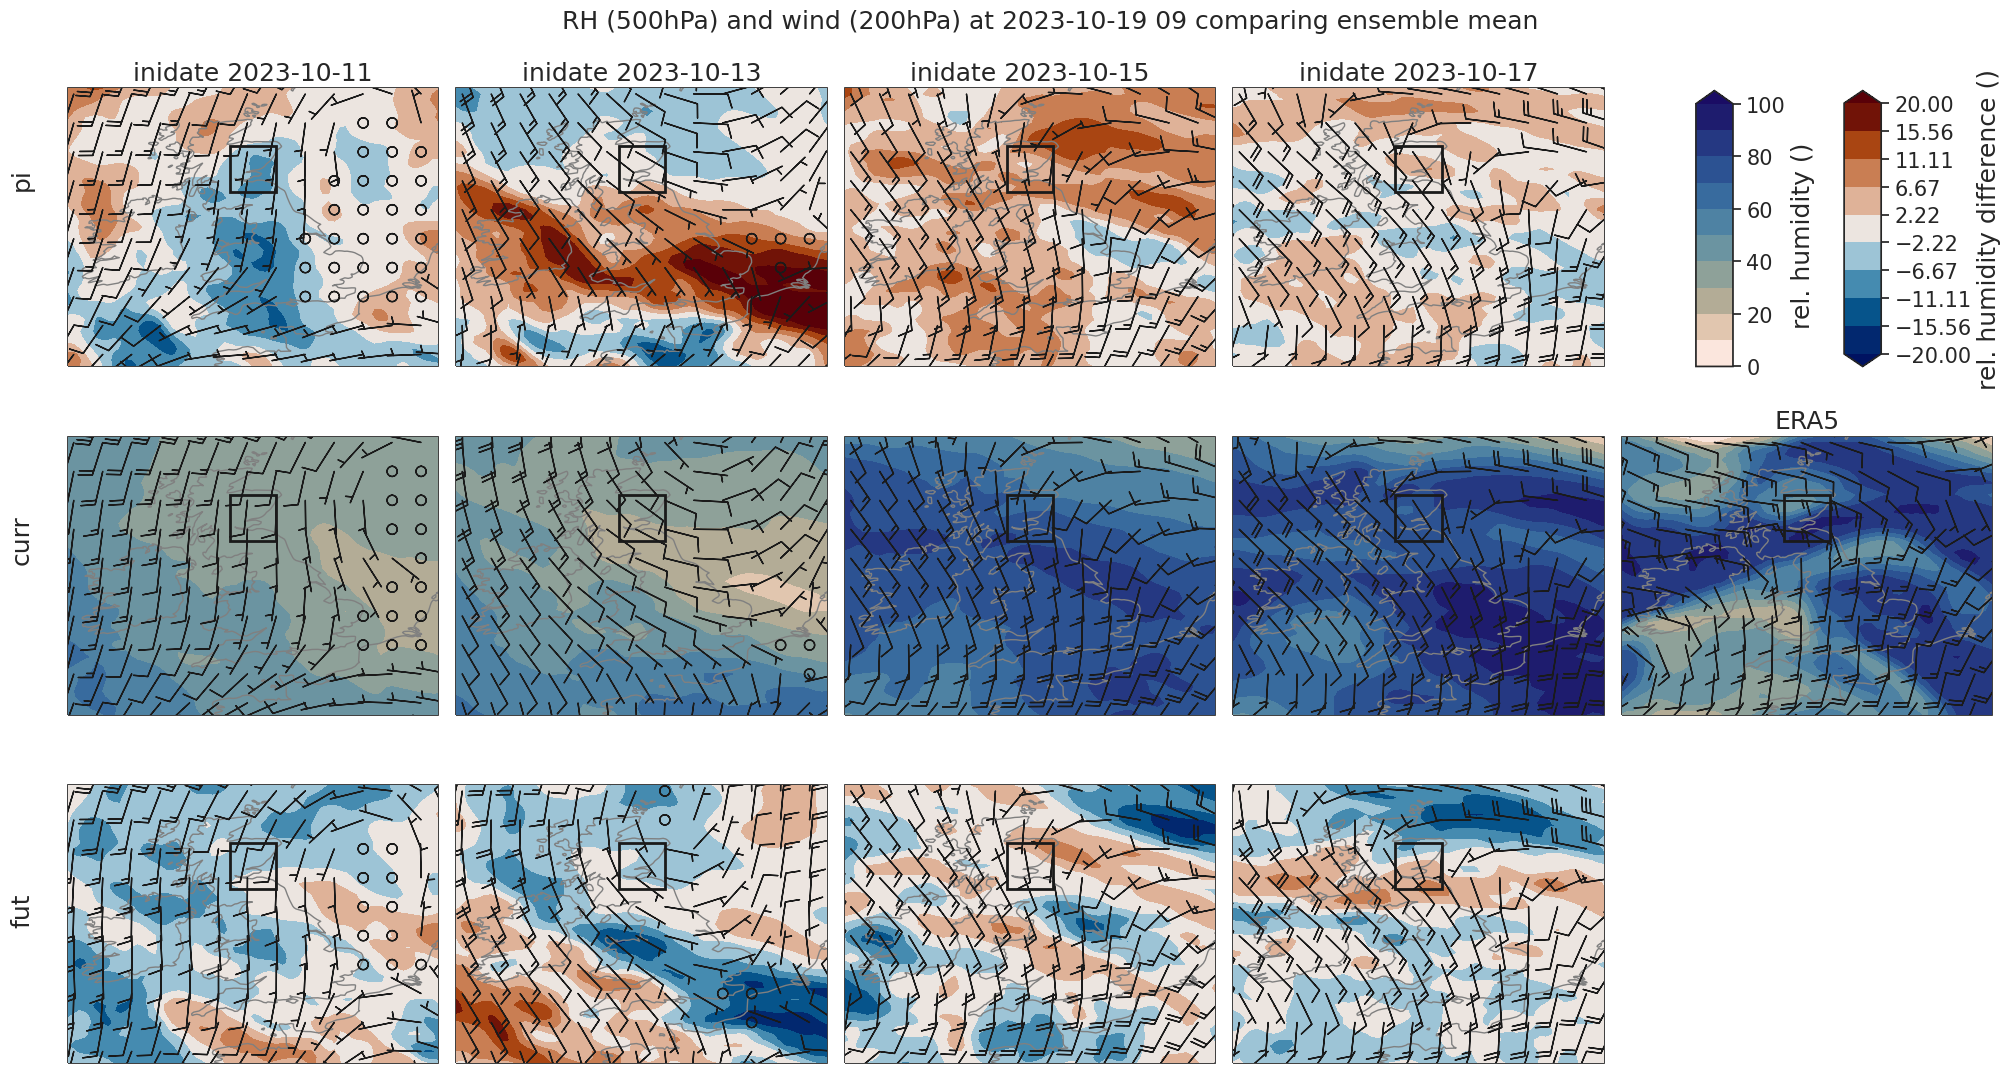

In [20]:
# figure and map setup
from matplotlib.pyplot import step


experiments = ['pi', 'curr', 'incr']
fs = 18
projection = ccrs.PlateCarree()
u_max = 30
u_min = 0

r_min = 0
r_max = 100

fig = plt.figure(1, figsize=(20, 11))
lead_times = ['inidate 2023-10-11', 'inidate 2023-10-13', 'inidate 2023-10-15', 'inidate 2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
timestep = '2023-10-19 09'
steps = 5

# EPS data ------------------    
latitude = exp['pi'].sel(inidate='2023-10-17').latitude.values
longitude = exp['pi'].sel(inidate='2023-10-17').longitude.values
# fewer grid points for wind barbs
thin_latitude = latitude[::steps]
thin_longitude = longitude[::steps]

for i, inidate in enumerate(inidates):
    for e, experiment in enumerate(experiments):
        u_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').u.values[::steps, ::steps]
        v_vals = (exp[experiment].sel(inidate=inidate, time=timestep, level=200)).mean(dim='number').v.values[::steps, ::steps]

        if experiment in ['pi', 'incr']:  # plot difference for counterfactual scenarios
            r_vals = (exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
        else: 
            r_vals = exp[experiment].r.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze().values

        ax = plt.subplot(3,5, i+1+e*5,projection = projection)
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')  #zorder > 10

        # humidity as shading
        if experiment =='curr':
            clevs_r = np.linspace(r_min, r_max, 11)
            cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.lapaz_r,
                            transform=projection, zorder = 13, extend = 'max')
        else: 
            clevs_r = np.linspace(-20, 20, 10)
            cf_diff = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.vik,
                                  transform=projection, zorder = 13, extend = 'both')
        
        # barbs for wind
        cs = ax.barbs(thin_longitude, thin_latitude, u_vals, v_vals, zorder = 16)
        if experiment=='pi':
            ax.set_title(lead_times[i], size = str(fs))
        else:
            ax.set_title('', size = str(fs))

        # rectangle for Aberdeenshire box
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                      edgecolor='k', 
                                      facecolor='none',
                                      transform=projection)
        ax.add_patch(rectangle)
        rectangle.set_zorder(17)

# ERA5 or analysis data ----------------------
latitude = era5.latitude
longitude = era5.longitude

u_vals = era5.u.sel(time=timestep, level=500).values[::steps, ::steps]
v_vals = era5.v.sel(time=timestep, level=500).values[::steps, ::steps]
r_vals = mpcalc.relative_humidity_from_specific_humidity(500 * units.hPa, 
                    era5.t.sel(time=timestep, level=500) * units.kelvin, 
                    era5.q.sel(time=timestep, level=500)).values*100

ax = plt.subplot(3,5,10,projection = projection)
ax.set_extent(uk, projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
ax.add_feature(cfeature.OCEAN, zorder=12, color='white')  # zorder > 10

# RH as shading
clevs_r = np.linspace(r_min, r_max, 11)
cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.lapaz_r,
                transform=projection, zorder=13, extend='max')

# wind as barbs
cs = ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)
ax.set_title("ERA5", size = fs)

# rectangle for Aberdeenshire box
rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
ax.add_patch(rectangle)
rectangle.set_zorder(17)

# Other figure settings -----------------
ax = plt.subplot(3,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='rel. humidity ()', extend = 'max', shrink=0.8)
cbar.set_label(label='rel. humidity ()', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = ax.inset_axes([0.6, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='rel. humidity difference ()', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='rel. humidity difference ()', size=fs)
cbar_diff.ax.tick_params(labelsize=fs-3)
plt.figtext(-0.02, 0.82, 'pi', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.48, 'curr', rotation='vertical', size=fs)
plt.figtext(-0.02, 0.15, 'fut', rotation='vertical', size=fs)
plt.suptitle('RH (500hPa) and wind (200hPa) at {} comparing ensemble mean'.format(timestep), size = fs)
plt.tight_layout()

plt.savefig('figures/08_r_winds_{}.png'.format(timestep), dpi=600)
plt.savefig('figures/08_r_winds_{}.pdf'.format(timestep))

In [19]:
mpcalc.relative_humidity_from_specific_humidity(500 * units.hPa, 
                                                era5.t.sel(time=timestep, level=500) * units.kelvin, 
                                                era5.q.sel(time=timestep, level=500)).values*100

array([[77.66368 , 78.39201 , 79.13962 , ..., 16.620749, 14.084458,
        11.305854],
       [79.43105 , 79.46417 , 79.49711 , ..., 12.031202, 10.800161,
         8.695028],
       [80.42705 , 80.5746  , 80.94689 , ...,  8.431165,  8.348836,
         8.258535],
       ...,
       [26.669363, 26.416122, 26.130352, ..., 12.068621, 12.175905,
        11.829057],
       [25.584614, 25.343159, 25.10467 , ..., 11.267335, 11.106269,
        10.374273],
       [23.92829 , 23.776636, 23.605747, ..., 10.080607,  9.315242,
         9.004489]], dtype=float32)

# Vertical velocity in time

In [21]:
# inidate = '2023-10-17'
# p_vals = (exp['pi'].sel(inidate=inidate, time=timestep, level=850)).mean(dim='number').z.values
# w_vals = (exp['pi'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze() - exp['curr'].w.sel(inidate=inidate, time=timestep, level=500).mean('number').squeeze()).values
# w_vals = exp['curr'].w.sel(inidate=inidate, level=500).mean('number').squeeze().values

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


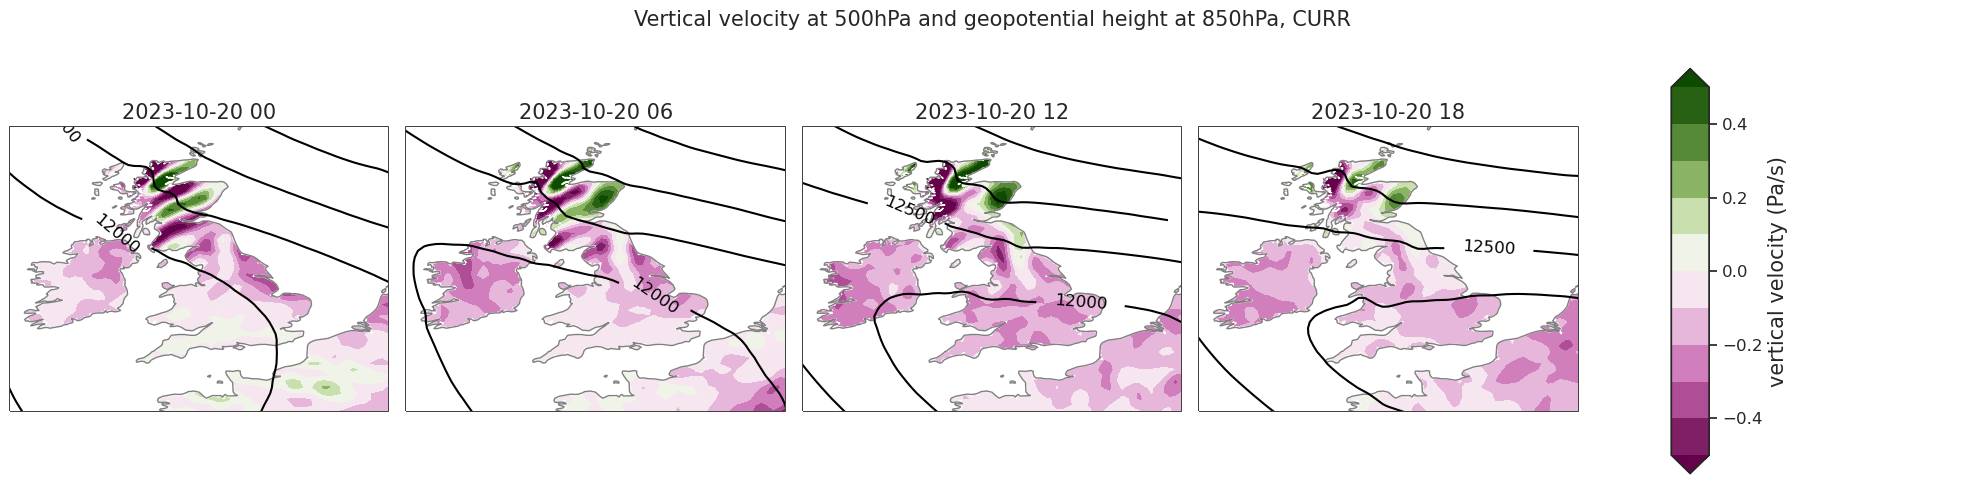

In [16]:
inidate = '2023-10-17'
projection = ccrs.PlateCarree()

# timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']
timesteps = ['2023-10-20 00', '2023-10-20 06', '2023-10-20 12', '2023-10-20 18']

fig = plt.figure(1, figsize=(20, 5)) 

w_min = -0.5
w_max = 0.5
p_min = 11000
p_max = 15000
fs = 15

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        # Get geopotential
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        
        # Calculate geopotential height
        z_vals = mpcalc.geopotential_to_height(units.Quantity(p_vals, 'm^2/s^2')).m 
        
        # Get vertical wind
        w_vals = exp['curr'].w.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        # Plot setup
        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        # Contours for GPH
        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, colors='black',
                        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        # Shading for vertical wind
        clevs_w = np.linspace(w_min, w_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='vertical velocity (Pa/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='vertical velocity (Pa/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Vertical velocity at 500hPa and geopotential height at 850hPa, CURR', size = fs)
plt.tight_layout()

In [5]:
def hourly2accum(ds, start_day='2023-10-18 09', end_day='2023-10-22 00', m2mm=True):
    """
    Function to convert hourly precipitation to accumulated precipitation in mm.
    Also truncates the data to the desired time period.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    ds_out: xarray dataset with precipitation accumulated in mm.
    """
    if m2mm:
        factor = 1000
    else:
        factor = 1
    ds_out = ds.copy(deep=True).sel(time=slice(start_day, end_day))
    ds_out['tp'] = ds_out.tp.cumsum(dim='time')*factor  # sum and convert to mm

    return ds_out

In [6]:
def accum2rate(ds):
    """
    Function to convert accumulated variables to conventional ones.
    Definition to convert accumulated variables to instantaneous.
    Written by Nick Leach.

    Input:
    ------

    Output:
    -------
    """

    dnew = ds.copy(deep=True)
    oindex = dnew.time
    dnew = dnew.diff('time') / (dnew.time.diff('time').astype(float) / 1e9 )
    dnew = dnew.reindex(time=oindex)
    return dnew[1:]

In [7]:
def preproc_ds(ds):
    """
    Main pre-processing function
    Writtten by Nick Leach and Shirin Ermis.

    Input:
    ------
    ds: xarray dataset

    Output:
    -------
    """

    # accumulated variables & scaling factors
    accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                        'ttr': 1,
                        'tsr': 1,
                        'str': 1,
                        'ssr': 1,
                        'e': 1}
    accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                'ttr': 'W m$^{-2}$',
                                'tsr': 'W m$^{-2}$',
                                'str': 'W m$^{-2}$',
                                'ssr': 'W m$^{-2}$',
                                'e': 'm s$^{-1}$'}
    ds1 = ds.copy().squeeze()
    # set up aux data
    inidate = pd.to_datetime(ds1.time[0].values)
    # expand dimensions to include extra info
    if not 'hDate' in ds1:
        ds1 = ds1.expand_dims({'inidate': [inidate]}).copy()

    if not 'number' in ds1:
        ds1 = ds1.expand_dims({'number': [0]}).copy()

    # put time dimension at front
    ds1 = ds1.transpose('time', ...)
    ds2 = ds1.copy(deep=True)

    # # convert accumulated variables into instantaneous
    # for var, sf in accumulated_vars.items():
    #     if var in ds2.keys():
    #         var_name = var+"_rate" 
    #         ds2 = ds2.assign(new=lambda x: accum2rate(x[var]) * sf)
    #         ds2 = ds2.rename_vars({'new':str(var_name)})
    #         ds2[var_name].loc[dict(time=ds2.time[1:])] = accum2rate(ds2[var]) * sf
    #         # set first value to equal zero,
    #         # should be zero but isn't always
    #         ds2[var_name].loc[dict(time=ds2.time[0])] = 0
    #         ds2[var_name].attrs['units'] = accumulated_var_newunits[var]
    return ds2

In [8]:
# Surface ERA5
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/sfc/'
sfc_era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'), engine='netcdf4')
sfc_era5 = sfc_era5.sel(time=slice('2023-10-17 00', '2023-10-22 00'))

In [12]:
# Surface experiment data
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
file_dir = {'curr': base_dir.format('curr'),
            'pi': base_dir.format('pi'),
            'incr': base_dir.format('incr')}
sfc_exp = {}
for experiment in file_dir.keys():
    sfc_exp[experiment] = xr.open_mfdataset(os.path.join(file_dir[experiment], '*.nc'), preprocess=preproc_ds, engine='netcdf4')

In [18]:
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
inidate = '2023-10-17'
t = '2023-10-20 09'

# Mean wind in Aberdeenshire region
w_exp_index = {key : exp[key].w.sel(inidate=inidate, time=t, level=500, latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']) for key in exp.keys()}
w_era_index = era5.w.sel(time=t, level=500, latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])

# Calculate cumulative precip
tp_era = hourly2accum(sfc_era5, start_day=starttime, end_day=endtime).tp.sel(time=endtime) # m2mm conversion in function
tp_exp = {key:(value.tp.sel(time=endtime, inidate=inidate)-value.tp.sel(time=starttime, inidate=inidate))*1000 for (key,value) in sfc_exp.items()}

# Mean cumulative precip in Aberdeenshire region
tp_exp_index = {key : value.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude']) for (key, value) in tp_exp.items()}
tp_era_index = tp_era.sel(latitude=slice(57.5, 55.5), longitude=slice(-4, -2)).mean(dim=['latitude', 'longitude'])

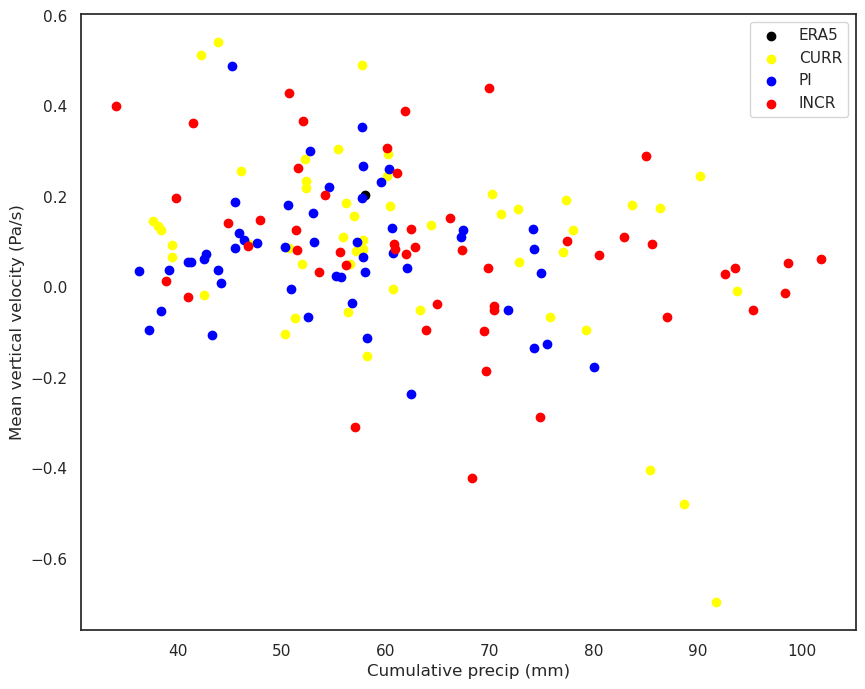

In [20]:
# Plot of precip index v wind index
fig, ax = plt.subplots(1,1, figsize=(10, 8))
ax.scatter(tp_era_index, w_era_index, label='ERA5', color='black')
ax.scatter(tp_exp_index['curr'], w_exp_index['curr'], label='CURR', color='yellow')
ax.scatter(tp_exp_index['pi'], w_exp_index['pi'], label='PI', color='blue')
ax.scatter(tp_exp_index['incr'], w_exp_index['incr'], label='INCR', color='red')
ax.set_xlabel('Cumulative precip (mm)')
ax.set_ylabel('Mean vertical velocity (Pa/s)')
ax.legend()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


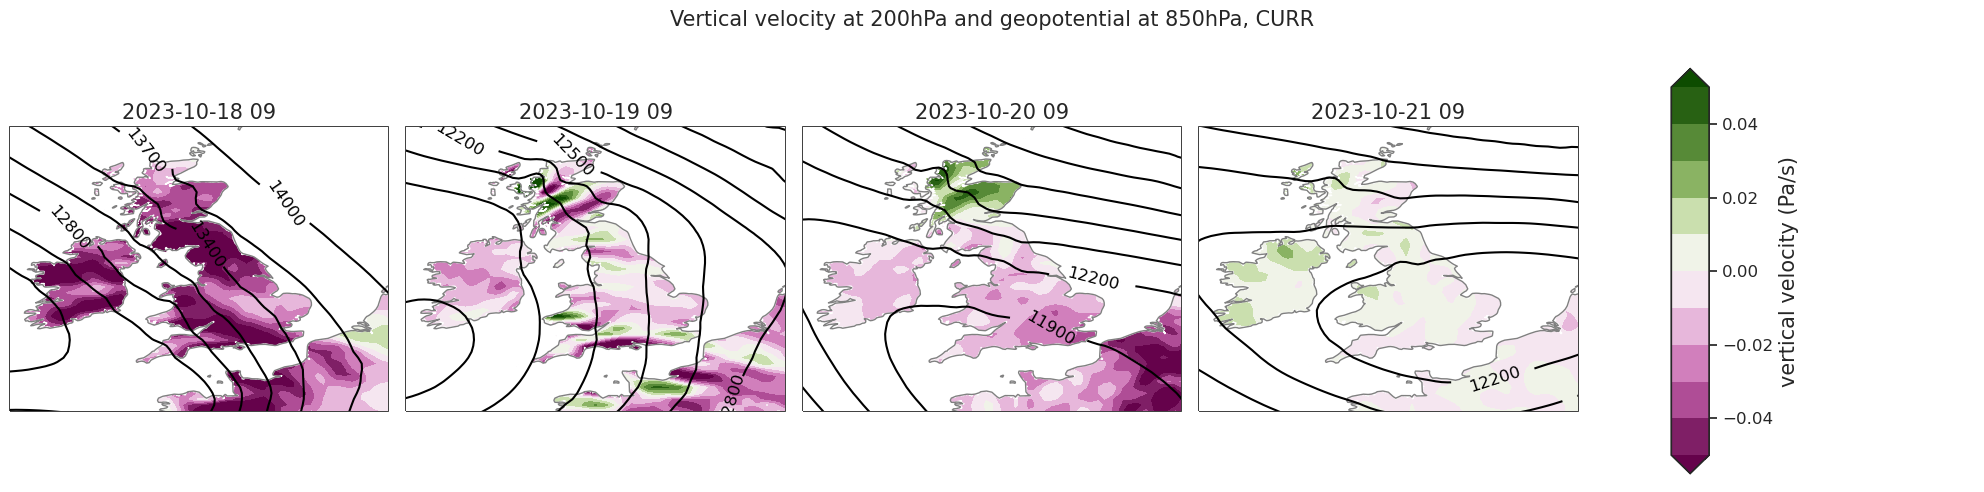

In [26]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(20, 5)) 

w_min = -0.05
w_max = 0.05
p_min = 11000
p_max = 15000

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values

for i,t in enumerate(timesteps):
        p_vals = (exp['curr'].sel(inidate=inidate, time=t, level=850)).mean(dim='number').z.values
        w_vals = exp['curr'].w.sel(inidate=inidate, time=t, level=200).mean('number').squeeze().values

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        clevs_p =np.arange(p_min, p_max, 300)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
        transform=projection, zorder = 16)
        plt.clabel(cs, fmt='%d', fontsize=fs-3)

        clevs_w = np.linspace(w_min, w_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, w_vals, clevs_w, cmap=cm.bam,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='vertical velocity (Pa/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='vertical velocity (Pa/s)', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Vertical velocity at 200hPa and geopotential at 850hPa, CURR', size = fs)
plt.tight_layout()

# Relative humidity in time

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


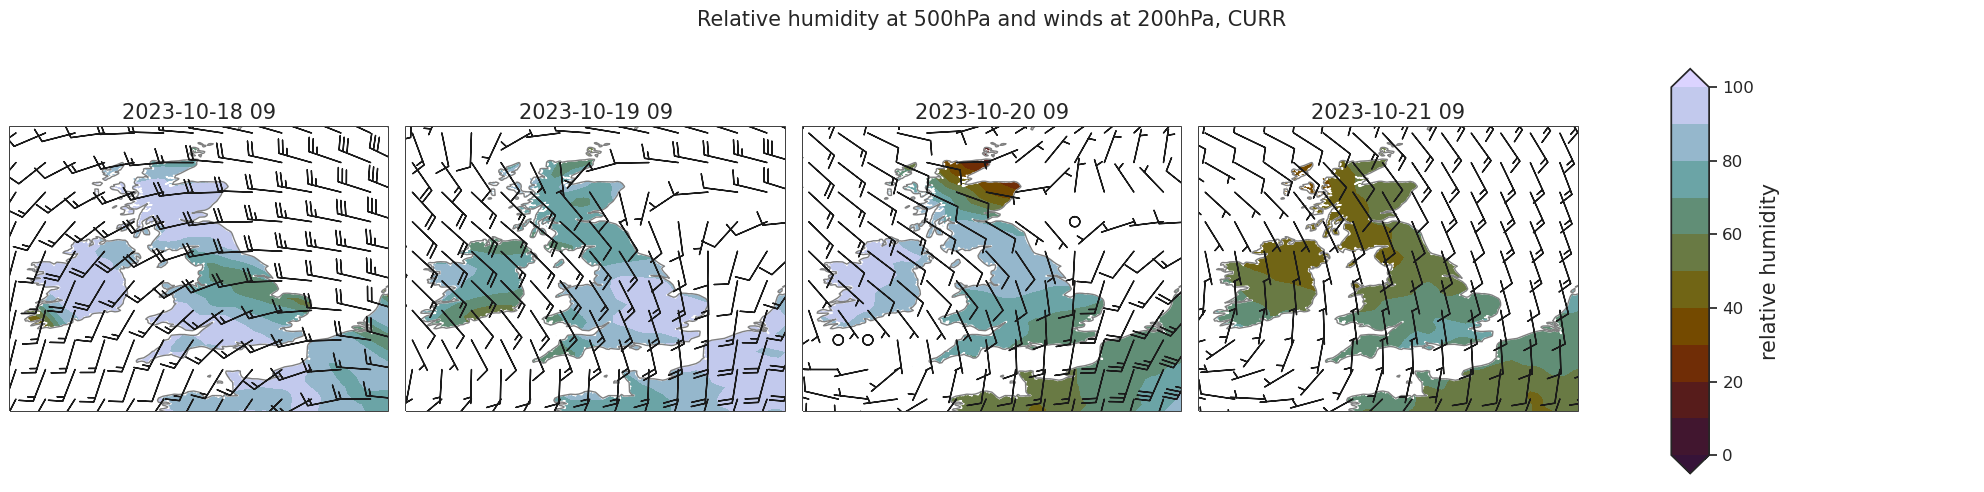

In [28]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(20, 5)) 

r_min = 0
r_max = 100

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values
thin_latitude = latitude[::5]
thin_longitude = longitude[::5]

for i,t in enumerate(timesteps):
        u_vals = (exp['curr'].sel(inidate=inidate, time=t, level=200)).mean(dim='number').u.values[::5, ::5]
        v_vals = (exp['curr'].sel(inidate=inidate, time=t, level=200)).mean(dim='number').v.values[::5, ::5]
        r_vals = exp['curr'].r.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)

        clevs_r = np.linspace(r_min, r_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.glasgow,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='relative humidity', extend = 'both', shrink=0.8)
cbar.set_label(label='relative humidity', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Relative humidity at 500hPa and winds at 200hPa, CURR', size = fs)
plt.tight_layout()

/home/e/ermis/nobackups/miniconda3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


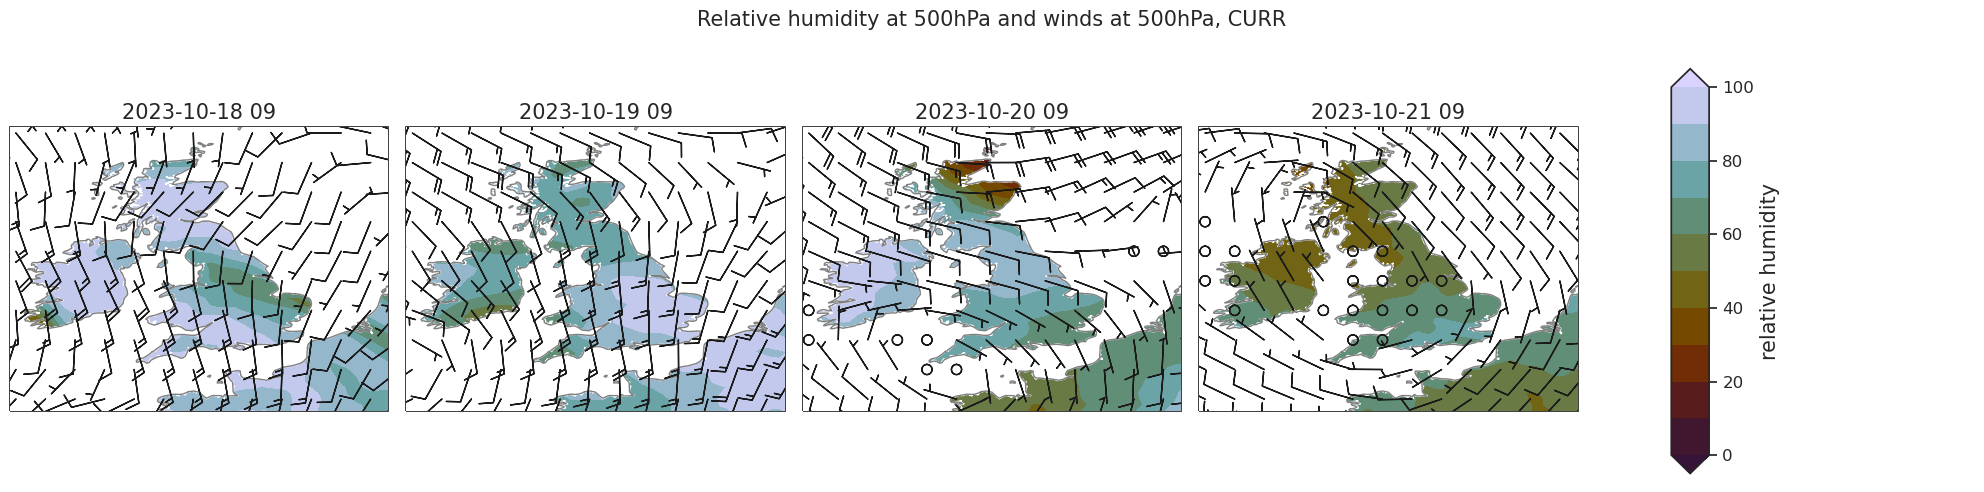

In [17]:
timesteps = ['2023-10-18 09', '2023-10-19 09', '2023-10-20 09', '2023-10-21 09']

plt.figure(1, figsize=(20, 5)) 

r_min = 0
r_max = 100

latitude = exp['curr'].sel(inidate='2023-10-17').latitude.values
longitude = exp['curr'].sel(inidate='2023-10-17').longitude.values
thin_latitude = latitude[::5]
thin_longitude = longitude[::5]

for i,t in enumerate(timesteps):
        u_vals = (exp['curr'].sel(inidate=inidate, time=t, level=500)).mean(dim='number').u.values[::5, ::5]
        v_vals = (exp['curr'].sel(inidate=inidate, time=t, level=500)).mean(dim='number').v.values[::5, ::5]
        r_vals = exp['curr'].r.sel(inidate=inidate, time=t, level=500).mean('number').squeeze().values

        ax = plt.subplot(1,5,i+1, projection=ccrs.PlateCarree())
        ax.set_extent(uk, projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey', zorder = 14)
        ax.add_feature(cfeature.OCEAN, zorder=12, color = 'white')

        ax.barbs(thin_longitude, thin_latitude, u_vals,v_vals, zorder = 16)

        clevs_r = np.linspace(r_min, r_max, 11)  # 17
        cf = ax.contourf(longitude, latitude, r_vals, clevs_r, cmap=cm.glasgow,
                transform=projection, zorder = 10, extend = 'both')
        
        plt.title(t, size=fs)

ax = plt.subplot(1,5,5)
ax.axis('off')  # removes subplot frame
cax = ax.inset_axes([0.2, 0.02, 0.1, 0.95])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='relative humidity', extend = 'both', shrink=0.8)
cbar.set_label(label='relative humidity', size=fs) 
cbar.ax.tick_params(labelsize=fs-3)

plt.suptitle('Relative humidity at 500hPa and winds at 500hPa, CURR', size = fs)
plt.tight_layout()